In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### import the ResNet model

In [ ]:
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)    # include_top=False means we could modify the output
print(base_model.summary())

In [ ]:
for i, layer in enumerate(base_model.layers):
  print(i, layer.name)

### Modify the tail network

In [4]:
NUM_CLASSES = 2

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
preds = tf.keras.layers.Dense(NUM_CLASSES, activation ='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=preds)
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

### Freeze the backbone of the model until layer 174

In [5]:
# for i, layer in enumerate(model.layers):
#   print(i, layer.name)

for layer in model.layers[:175]:
  layer.trainable = False

for layer in model.layers[175:]:
  layer.trainable = True

### Load dataset from GoogleDrive

In [6]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')
%pwd

/
Mounted at /content/gdrive


'/'

In [9]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [7]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

train_generator = train_datagen.flow_from_directory('/content/gdrive/My Drive/Transfer_Learning_with_ResNet/train/', 
                           target_size = (224, 224),
                           color_mode = 'rgb',
                           batch_size = 32,
                           class_mode = 'categorical',
                           shuffle = True)

Found 320 images belonging to 2 classes.


### Train

In [8]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit_generator(generator=train_generator, 
                steps_per_epoch=train_generator.n//train_generator.batch_size,
                epochs = 5)


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
10/10 [==============================] - 107s 11s/step - loss: 0.8910 - accuracy: 0.7219
Epoch 2/5
10/10 [==============================] - 1s 91ms/step - loss: 0.0607 - accuracy: 0.9812
Epoch 3/5
10/10 [==============================] - 1s 92ms/step - loss: 0.0115 - accuracy: 0.9969
Epoch 4/5
10/10 [==============================] - 1s 93ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 5/5
10/10 [==============================] - 1s 90ms/step - loss: 0.0027 - accuracy: 0.9969


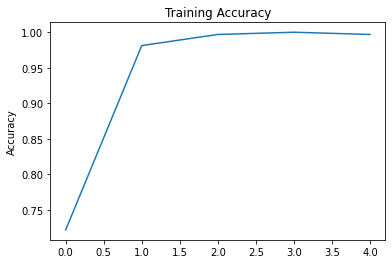

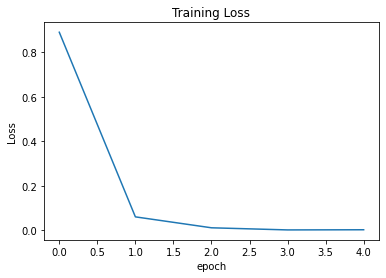

In [10]:
acc = history.history['accuracy']
loss = history.history['loss']

plt.figure()
plt.plot(acc, label='Training Accuracy')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.figure()

plt.plot(loss, label='Training Loss')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

### Predict

In [23]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
test_generator = test_datagen.flow_from_directory('/content/gdrive/My Drive/Transfer_Learning_with_ResNet/test/', 
                           target_size = (224, 224),
                           color_mode = 'rgb',
                           batch_size = 1,
                           class_mode = 'categorical',
                           shuffle = False)

pred = model.predict_generator(test_generator, verbose=1)  # make prediction

Found 29 images belonging to 1 classes.
29/29 [==============================] - 0s 9ms/step


In [26]:
predicted_class_indices = np.argmax(pred, axis=1)    # return the index of the maximum along axis
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames = test_generator.filenames
results = pd.DataFrame({"Filename":filenames, "Predictions":predictions})

print(results)

              Filename Predictions
0      test/blue_0.png        blue
1      test/blue_1.png        blue
2     test/blue_10.png        blue
3     test/blue_11.png        blue
4     test/blue_12.png        blue
5     test/blue_13.png        blue
6     test/blue_14.png        blue
7      test/blue_2.png        blue
8      test/blue_3.png        blue
9      test/blue_4.png        blue
10     test/blue_5.png        blue
11     test/blue_6.png        blue
12     test/blue_7.png        blue
13     test/blue_8.png        blue
14     test/blue_9.png        blue
15   test/yellow_0.png      yellow
16   test/yellow_1.png      yellow
17  test/yellow_10.png      yellow
18  test/yellow_11.png      yellow
19  test/yellow_12.png      yellow
20  test/yellow_13.png      yellow
21   test/yellow_2.png      yellow
22   test/yellow_3.png      yellow
23   test/yellow_4.png      yellow
24   test/yellow_5.png      yellow
25   test/yellow_6.png      yellow
26   test/yellow_7.png      yellow
27   test/yellow_8.p